**Import the necessary packages**

In [222]:
import tensorflow as tf
import numpy as np
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping






**Mount the drive to import the pretrained model**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
model= load_model('/content/drive/MyDrive/model.h5')

In [5]:
model.summary()

Model: "OCRModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0  

Some useful functions:

* decode_prediction( pred ->a number in [0, 35]) return predicted class 0-9 / A-Z
*  resize(image) -> resize an image 

* process_image(image) -> apply some processing on the image and get the text from it


In [6]:
def decode_prediction(num):
  if num < 10:
    return str(num)
  else:
    return chr(65 + int(num) - 10)

In [8]:
import cv2

def resize(image, width = None, height = None, inter = cv2.INTER_AREA):
  dim = None
  (h, w) = image.shape[:2]

  if width is None and height is None:
     return image
  
  if width is None:
    r = height / float(h)
    dim = ( int(w*r), height)
  else:
    r = width / float(w)
    dim = (width, int(r*h))

  resized = cv2.resize(image, dim, interpolation = inter)
  return resized



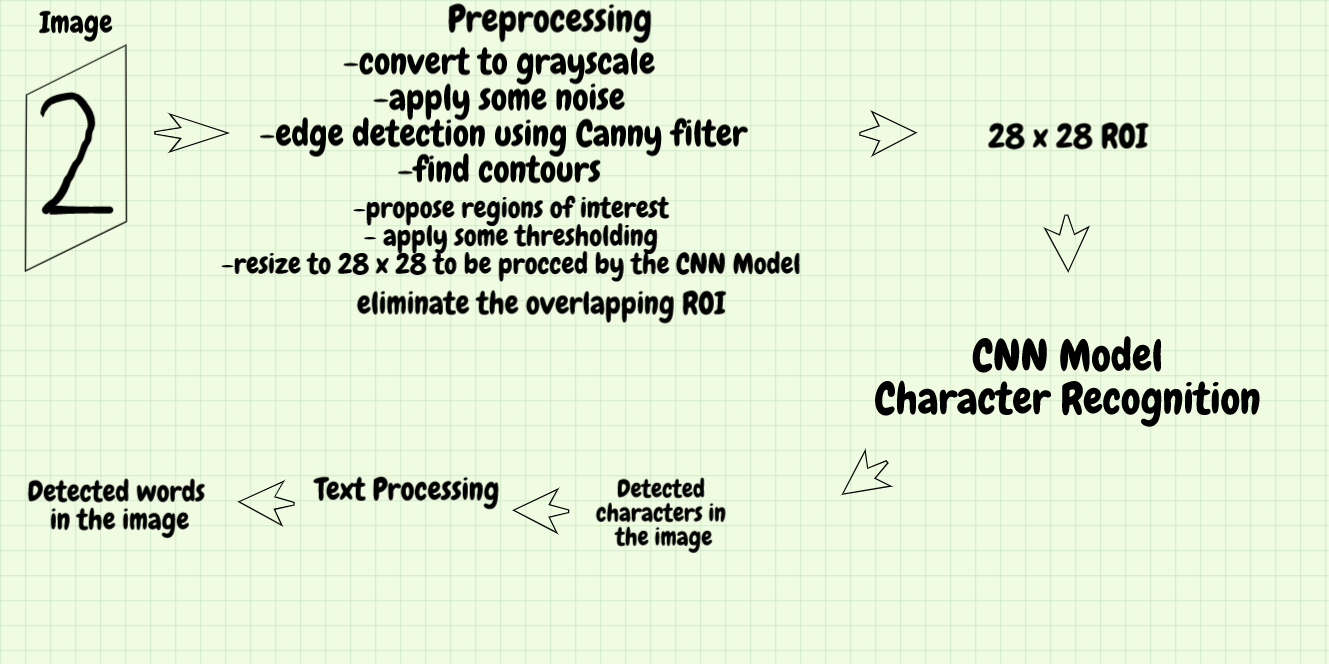

In [229]:

from google.colab.patches import cv2_imshow
def process_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.GaussianBlur(img, (5, 5), 0)
  cv2_imshow(img)
  # edge detection
  edged = cv2.Canny(img, 30, 50)
  cv2_imshow(edged)

  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  boundingBoxes = [cv2.boundingRect(c) for c in cnts]
  (cnt, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key = lambda x: x[1][1], reverse = False))
  cnts = (cnt, boundingBoxes)[0]
  chars = []

  for c in cnts:
    
    (x, y, w, h)  = cv2.boundingRect(c)
    if( w >= 4 and w <= 220) and ( h >= 25 and h <= 220):
      roi = img[ y: y + h, x: x + w]
      cv2_imshow(roi)
      thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
      (th, tw) = thresh.shape

      if tw > th : thresh = resize(thresh, width = 28)
      else: thresh = resize(thresh, height = 28)

      (th, tw) = thresh.shape
      dx = int(max(0, 28 - tw) / 2.0)
      dy = int(max(0, 28 - th) / 2.0)

      padded = cv2.copyMakeBorder(thresh, top = dy, bottom = dy, left = dx, right = dx, borderType = cv2.BORDER_CONSTANT, value = (0, 0, 0))
      padded = cv2.resize(padded, (28, 28))

      padded = padded.astype("float32") / 255.0
      padded = np.expand_dims(padded, axis = -1)
      chars.append((padded, (x, y, w, h)))

  boxes = [b[1] for b in chars]
  #boxes = resolveOverlay(np.array(boxes), 0.1)
  chars = np.array( [b[0] for b in chars], dtype = "float32")
  

  preds = model.predict(chars)
  best = np.argmax(preds)
  text = ""
  points = []
  
  d = {}

 # first y coordinate
  y_last = boxes[0][1]
  x_last = boxes[0][1]
  text = ""
  word = ""


  forsort = []
  x_coord = []
  txt = []
  words = []
  
  for i, (pred, (x, y, w, h)) in enumerate(zip(preds, boxes)):

  
    i = np.argmax(pred)
    char = decode_prediction(i)
    if abs(y - y_last) < 35:
      #word += char
      x_coord.append(x)
      words.append(char)
    else:
      txt.append(words)
      words = []
      forsort.append(x_coord)
      x_coord = []

    center =  ( x + (w // 2) , y + (h // 2))
    points.append(center)
    cv2.circle(img, center, radius=0, color=(0, 0, 255), thickness=1)
    
    d[center] = char

    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
    cv2.putText(img, char, (x-12, y-12), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    y_last = y


  forsort.append(x_coord)
  #print("x:", forsort)
  txt.append(words)
  #print("txt:",txt)

  result = []
  for x_list, chars in zip(forsort, txt):
    xs = np.argsort(x_list)
    newtext = [chars[i] for i in xs]

    #print(x_list, chars)
    #print(newtext)
    result.append("".join(newtext))


  cv2_imshow(img)

  return result

Quick demo using webcam

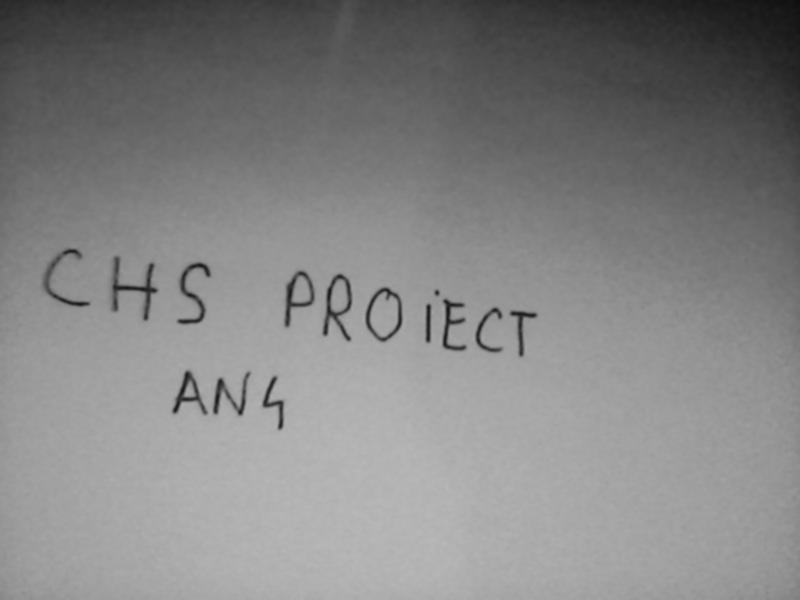

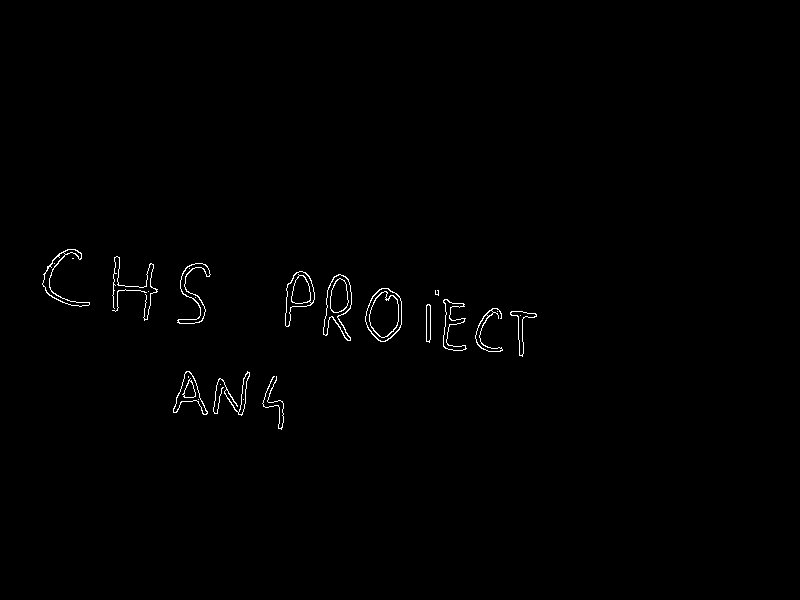

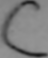

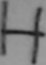

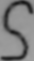

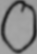

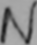

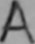

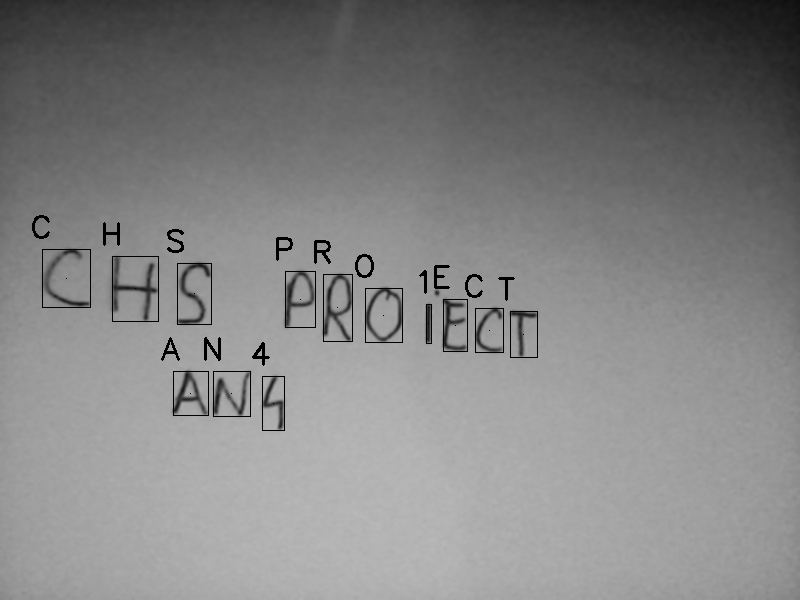

In [232]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] =[video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

img = take_photo()
pred = process_image(img)

In [233]:
import math

def process_text(text_list):
  result = []
  for word in text_list:
    wlist = [w for w in word]
    for i in range(len(wlist)-1):
      if wlist[i] == "1" and ( wlist[i-1].isalpha() or  wlist[i-1].isalpha()):
        wlist[i] = "I"
      if wlist[i] == "0" and ( wlist[i-1].isalpha() or  wlist[i-1].isalpha()):
        wlist[i] = "O"
    result.append("".join(wlist))
  return result



In [234]:
print(process_text(pred))

['CHSPROIECT', 'A4']


Making prediction for unseen images

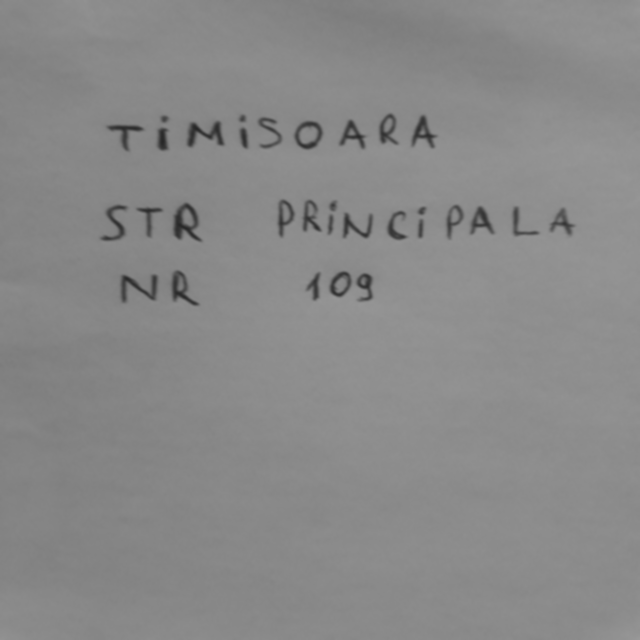

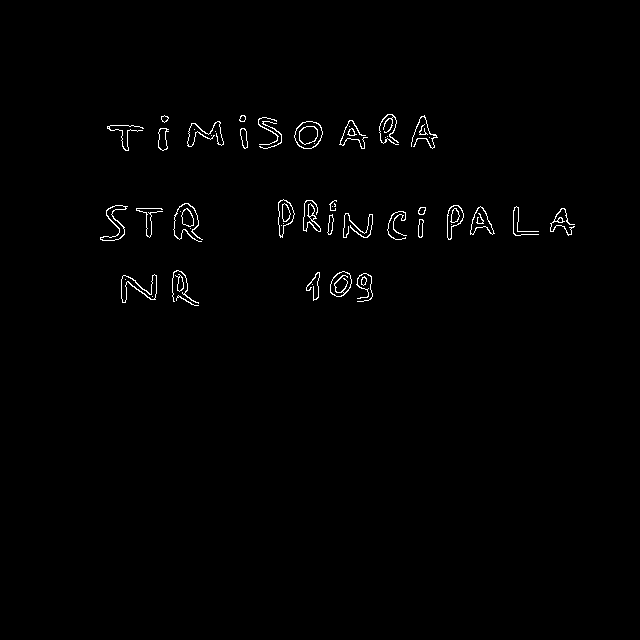

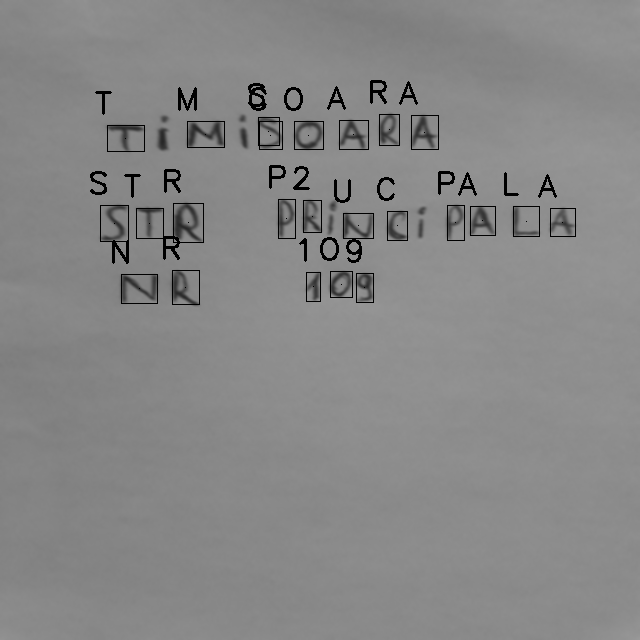

['TMSCOARA', 'STR2UCPALA', 'N1O9']


In [231]:
img_1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/testadresa.jpg')
img_1 = cv2.resize(img_1, (640, 640))
p = process_image(img_1)
print(p)

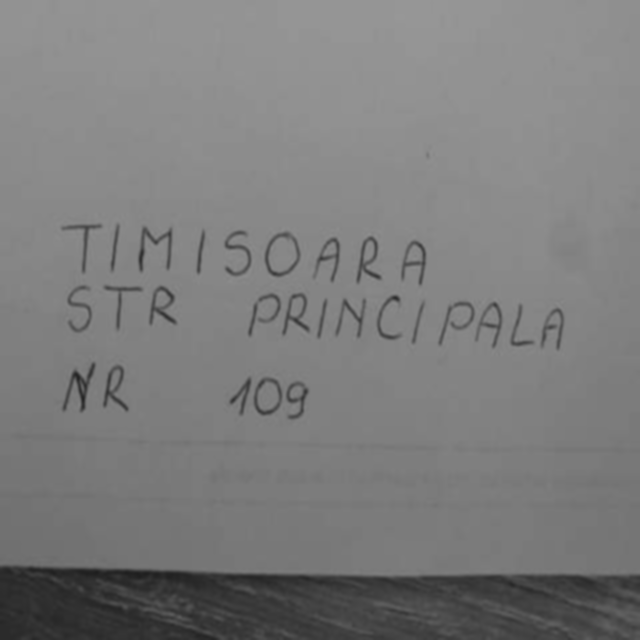

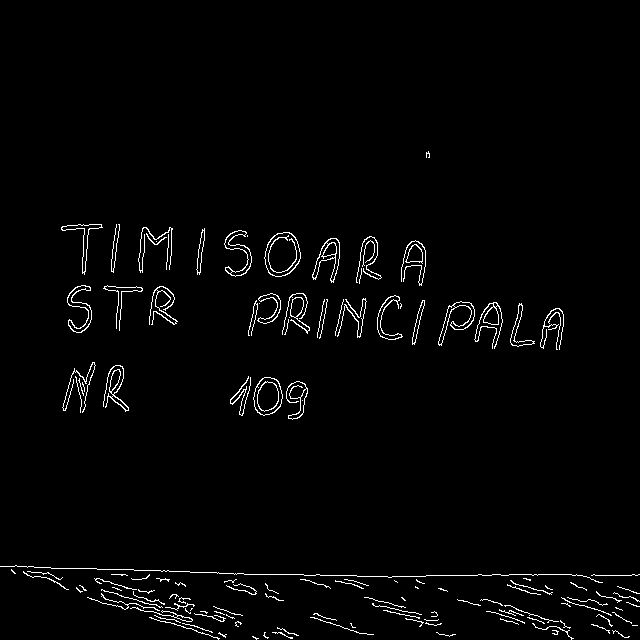

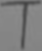

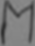

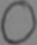

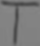

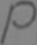

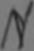

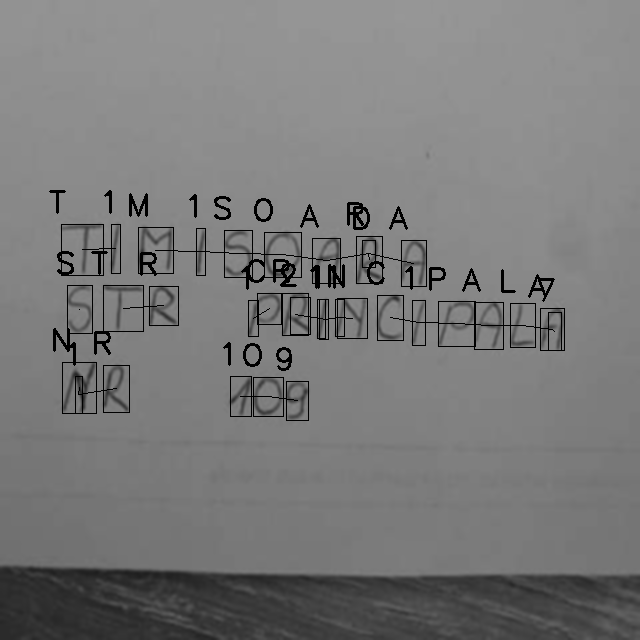

['T1M1SOARDA', 'SR1CR2111NC1PALA7', '1R1O9']
['TIMISOARDA', 'SRICR2111NCIPALA7', '1RIO9']


In [228]:
img_1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/image.jpeg')
img_1= cv2.resize(img_1, (640, 640))
p = process_image(img_1)
print(p)

text = process_text(p)
print(text)

Possible improvements:
* Merging overlapping regions of interest
*   Better quality data
*   More complex models ( both text detector and text recognition model)
*   Text processing ( a neural network (RNN / Attention Based Model)
*   Text processing. Ex: Levenshtein Distance and Cosine Similarity with respect to the problem needed to be resolved  



Levenshtein Distance and Cosine Similarity

In [218]:
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    result = int(matrix[size_x - 1, size_y - 1])
    print ("Levenshtein dist. between " + str(seq1) + " and " + str(seq2) + " is " + str(result))
    print("It means an :" + str( round(result / len(str(seq1)), 2)) + " change" )
    return result


In [219]:


l1 =levenshtein("TIMISOARA", "T1M1SOARDA")
l2 =levenshtein("TIMISOARA", "TIMISOARDA")


Levenshtein dist. between TIMISOARA and T1M1SOARDA is 3
It means an :0.33 change
Levenshtein dist. between TIMISOARA and TIMISOARDA is 1
It means an :0.11 change


In [214]:
def cosine_sim(word1, word2):
  f1 = 36 * [0]
  f2 = 36 * [0]

  w1 = [w for w in word1]
  w2 = [w for w in word2]

  print(w1)
  print(w2)

  for w in w1:
    if w.isdigit():
      f1[ord(w)- 48] += 1
    elif w.isalpha():
      f1[ord(w) - 65 + 10] += 1
  for w in w2:
    if w.isdigit():
      f2[ord(w) - 48] += 1
    elif w.isalpha():
      f2[ord(w) - 65 + 10] += 1

  dist = np.dot(f1, f2) / (np.linalg.norm(f1) * np.linalg.norm(f2))
  print("Cosine sim. is " + str(dist))
  return dist

In [215]:
l1 =cosine_sim("TIMISOARA", "T1M1SOARDA")
l2 =cosine_sim("TIMISOARA", "TIMISOARDA")


['T', 'I', 'M', 'I', 'S', 'O', 'A', 'R', 'A']
['T', '1', 'M', '1', 'S', 'O', 'A', 'R', 'D', 'A']
Cosine sim. is 0.6671243849949912
['T', 'I', 'M', 'I', 'S', 'O', 'A', 'R', 'A']
['T', 'I', 'M', 'I', 'S', 'O', 'A', 'R', 'D', 'A']
Cosine sim. is 0.9636241116594316
